In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import PolarimetryMap2, FaradayMap2, NeLMap2, Interferogram, OpticalFrames
import scipy.constants as c
from mcerp import N, umath, Gamma
from bdots import *
import pickle
import csv
import string
letters=list(string.ascii_lowercase)


class TS_fibre_data:
    def __init__(self, fn):
        shift=[]
        Background=[]
        Response=[]
        Shot=[]
        Fit=[]

        with open(fn, 'r',newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)
            next(reader)
            for row in reader:
                shift.append(float(row[0]))
                Background.append(float(row[1]))
                Response.append(float(row[2]))
                Shot.append(float(row[3]))
                Fit.append(float(row[4]))

        self.shift=np.asarray(shift)
        self.Background=np.asarray(Background)
        self.Response=np.asarray(Response)
        self.Shot=np.asarray(Shot)
        self.Fit=np.asarray(Fit)

# Sample Spectra for s0611_15

In [2]:
%cd "~\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns\shot"
ts=np.loadtxt('s0611_15 shot (corrupted line removed).asc')
ts=np.rot90(ts)
roi=np.flipud(ts[:270,980:1056])

%cd "~\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns"
A1=TS_fibre_data("s0611_15_1A_data_and_fit.dat")
A8=TS_fibre_data("s0611_15_8A_data_and_fit.dat")

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns\shot
C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns


<IPython.core.display.Javascript object>


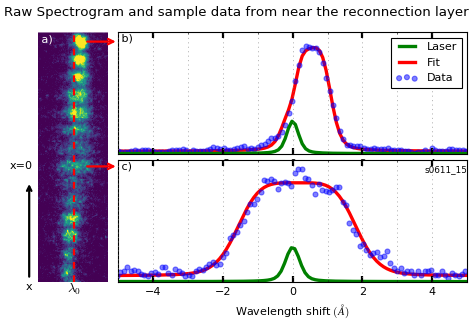

In [78]:
fig=plt.figure(figsize=(5.9,4))

ax1=fig.add_axes([0.05, 0.12, 0.2, 0.78])#l,b,w,h
ax1.imshow(roi, clim=[620,800], cmap=cmaps.viridis, interpolation='none')
ax1.plot([38,38],[0,270], lw=2, color='red', ls='--')
ax1.set_ylim([0,270])
ax1.axis('off')
ax1.text(x=38, y=0, va='top',ha='center',s=r'$\lambda_0$', fontsize=12)
ax1.text(x=0.1, y=0.99, va='top',ha='left',s=r' a)', color='white',fontsize=10,transform=ax1.transAxes)


ax2=fig.add_axes([0.25, 0.52, 0.74, 0.38])#l,b,w,h
ax3=fig.add_axes([0.25, 0.12, 0.74, 0.38],sharex=ax2)#l,b,w,h


for a, f in zip([ax2,ax3], [A1, A8]):
    r=0.3*f.Shot.max()/f.Response.max()
    a.plot(f.shift, f.Response*r, lw=3, color='green', label='Laser')
    a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1)
    a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2, alpha=0.5)

    a.set_ylim([0,None])
    a.tick_params(labelsize=10, pad=5, length=5, width=2)
    a.set_yticks([])

    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.grid(which='minor', color='gray',linestyle=':')
    
ax2.legend(fontsize=10, loc=1)
#ax2.set_xticklabels([])
ax3.set_xlim([-5,5])
#ax3.set_xticks([-2,-1,0,1,2])
ax3.set_xlabel(r'Wavelength shift $(\AA)$',fontsize=10)
ax2.text(x=0, y=0.99, va='top',ha='left',s=r' b)',transform=ax2.transAxes,fontsize=10)
ax3.text(x=0, y=0.99, va='top',ha='left',s=r' c)',transform=ax3.transAxes,fontsize=10)
ax3.text(x=1, y=0.96, va='top',ha='right',s='s0611_15',transform=ax3.transAxes,fontsize=8)


fig.suptitle('Raw Spectrogram and sample data from near the reconnection layer', fontsize=12)

ax1.annotate('',xy=(0.25,0.87),xycoords='figure fraction',xytext=(0.18,0.87),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

ax1.annotate('',xy=(0.25,0.48),xycoords='figure fraction',xytext=(0.18,0.48),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

ax1.annotate('x',xy=(0.0,0.4),xycoords='axes fraction',textcoords='axes fraction',xytext=(0.0,0),
             arrowprops=dict(arrowstyle='->',fc='k',ec="k",lw=2),
            ha='center', va='top', fontsize=10)


ax1.annotate('x=0',xy=(0.25,0.48),xycoords='figure fraction',xytext=(0.02,0.48),
            ha='left', va='center', color='black', fontsize=10)





In [79]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0611_15_thomson_inflow.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Profiles for s0611_15

In [4]:
%cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

x_pos=[]
n_e=[]
Z=[]
T_e=[]
T_e_err=[]
T_i=[]
T_i_err=[]
V=[]
V_err=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        x_pos.append(float(row[3]))
        n_e.append(float(row[5]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        tee=float(row[8])
        if tee==0:
            T_e_err.append(float(row[7])/10.0)
        else:
            T_e_err.append(tee)
        T_i.append(float(row[9]))
        tie=float(row[10])
        if tie==0:
            T_i_err.append(float(row[9])/10.0)
        else:
            T_i_err.append(tie)
        V.append(float(row[11]))
        ve=float(row[12])
        if tie==0:
            V_err.append(float(row[11])/10.0)
        else:
            V_err.append(ve)
        
x=np.array(x_pos)*1e-3
n_e=np.array(n_e)*1e6
n_e_err=(np.zeros_like(n_e)+0.3e17)*1e6 
Z=np.array(Z)
T_e=np.array(T_e)
T_e[11]=15 #set to avg.
T_e_err=np.array(T_e_err)
T_i=np.array(T_i)
T_i_err=np.array(T_i_err)
V=np.array(V)*1e3
V_err=np.array(V_err)*1e3 

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15


<IPython.core.display.Javascript object>


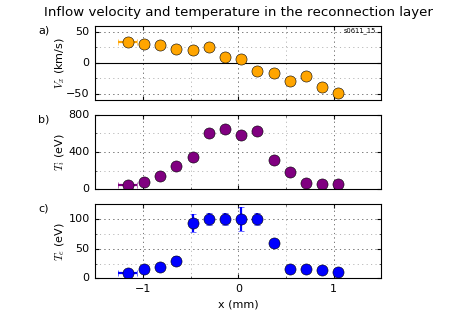

In [338]:
x_mm=x*1e3
x_err=np.zeros_like(x_mm)+0.1
ms=10
lfs=10
tfs=10
elw=2

fig, (a0,a1,a2)=plt.subplots(3,1,figsize=(5.96,4), sharex=True)
#single x error_bar per plot

a0.errorbar(x_mm[0], xerr=x_err[0], y=(V/1e3)[0], yerr=(V_err/1e3)[0], color='orange', fmt='o',markersize=ms,elinewidth=elw)
a1.errorbar(x_mm[0], xerr=x_err[0], y=T_i[0], yerr=T_i_err[0],  color='purple', fmt='o',markersize=ms,elinewidth=elw)
a2.errorbar(x_mm[0], xerr=x_err[0], y=T_e[0], yerr=T_e_err[0],  color='blue', fmt='o',markersize=ms,elinewidth=elw)

#data points

a0.errorbar(x_mm[1:], y=(V/1e3)[1:], yerr=(V_err/1e3)[1:],  label=r'$V_in$', color='orange', fmt='o',markersize=ms,elinewidth=elw)
a1.errorbar(x_mm[1:], y=T_i[1:], yerr=T_i_err[1:], label=r'$T_i$', color='purple', fmt='o',markersize=ms,elinewidth=elw)
a2.errorbar(x_mm[1:], y=T_e[1:], yerr=T_e_err[1:],label=r'$T_e$', color='blue', fmt='o',markersize=ms,elinewidth=elw)

a0.plot([-2,2],[0,0], lw=1, color='black', zorder=1)
   

a=a0
a.set_xlim([-1.5,1.5])
a.set_xticks([-1,0,1])
a.xaxis.set_minor_locator(MultipleLocator(0.5))

a.set_ylim([-60,60])
a.set_yticks([-50,0,50])
a.yaxis.set_minor_locator(MultipleLocator(25))
a.set_ylabel(r'$V_{x}$ (km/s)', fontsize=lfs)

a=a1

a.set_ylim([0,800])
a.set_yticks([0,400,800])
a.yaxis.set_minor_locator(MultipleLocator(200))

a.set_ylabel(r'$T_i$ (eV)', fontsize=lfs)

a=a2
a.set_ylim([0,125])
a.set_yticks([0,50,100])
a.yaxis.set_minor_locator(MultipleLocator(25))


a.set_ylabel(r'$T_e$ (eV)', fontsize=lfs)


a.set_xlabel('x (mm)', fontsize=lfs)

for i, a in enumerate((a0,a1,a2)):
    a.tick_params(labelsize=tfs, pad=5, length=4, width=1)
    a.get_yaxis().set_label_coords(-0.1,0.5)
    a.grid()
    a.grid(which='minor', color='gray',linestyle=':')
    a.set_axisbelow(True)
    a.annotate(s=letters[i]+')', xy=(-0.2, 0.9),fontsize=10,xycoords='axes fraction')

plt.subplots_adjust(left=0.2, bottom=0.13, right=0.8, top=0.92,
                wspace=0.1, hspace=0.2)

a0.text(s='s0611_15', x=1.1, y=50,fontsize=6)


fig.suptitle('Inflow velocity and temperature in the reconnection layer',fontsize=12, x=0.5)

In [339]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0611_15_thomson_profiles.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

<IPython.core.display.Javascript object>


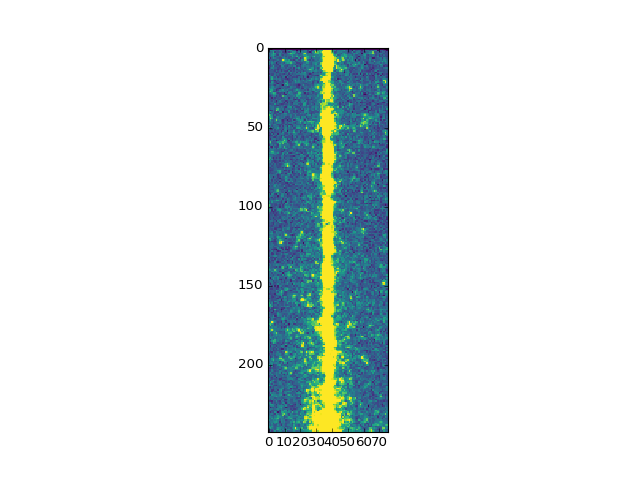

In [5]:
roiB=np.flipud(ts[270:,980:1056])
fig,ax=plt.subplots()
ax.imshow(roiB, clim=[600,650], cmap=cmaps.viridis, interpolation='none')

# Sample spectra for s1006_15

In [70]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow\s1006_15 TS\sh"
ts=np.loadtxt('s1006_15 shot v2.asc')
ts=np.rot90(ts)
l0=1025
w=38
roi=np.flipud(ts[:270,l0-w:l0+w])

%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow\s1006_15 TS"
A11=TS_fibre_data("s1006_15 TS F11A.dat")
A8=TS_fibre_data("s1006_15 TS F8A.dat")

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow\s1006_15 TS\sh
C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow\s1006_15 TS


<IPython.core.display.Javascript object>


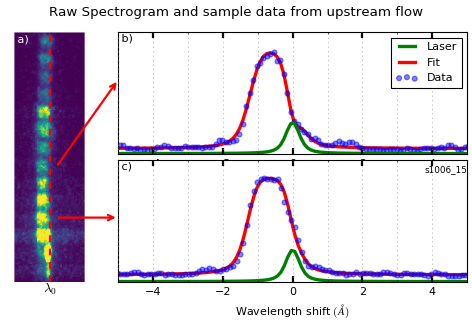

In [71]:
fig=plt.figure(figsize=(5.9,4))

ax1=fig.add_axes([0.0, 0.12, 0.2, 0.78])#l,b,w,h
ax1.imshow(roi, clim=[620,1000], cmap=cmaps.viridis, interpolation='none')
ax1.plot([38,38],[0,270], lw=2, color='red', ls='--')
ax1.set_ylim([0,270])
ax1.axis('off')
ax1.text(x=38, y=0, va='top',ha='center',s=r'$\lambda_0$', fontsize=12)
ax1.text(x=0.1, y=0.99, va='top',ha='left',s=r' a)', color='white',fontsize=10,transform=ax1.transAxes)


ax2=fig.add_axes([0.25, 0.52, 0.74, 0.38])#l,b,w,h
ax3=fig.add_axes([0.25, 0.12, 0.74, 0.38],sharex=ax2)#l,b,w,h


for a, f in zip([ax2,ax3], [A8, A11]):
    r=0.3*f.Shot.max()/f.Response.max()
    a.plot(f.shift, f.Response*r, lw=3, color='green', label='Laser')
    a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1)
    a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2, alpha=0.5)

    a.set_ylim([0,None])
    a.tick_params(labelsize=10, pad=5, length=5, width=2)
    a.set_yticks([])

    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.grid(which='minor', color='gray',linestyle=':')
    
ax2.legend(fontsize=10, loc=1)
#ax2.set_xticklabels([])
ax3.set_xlim([-5,5])
#ax3.set_xticks([-2,-1,0,1,2])
ax3.set_xlabel(r'Wavelength shift $(\AA)$',fontsize=10)
ax2.text(x=0, y=0.99, va='top',ha='left',s=r' b)',transform=ax2.transAxes,fontsize=10)
ax3.text(x=0, y=0.99, va='top',ha='left',s=r' c)',transform=ax3.transAxes,fontsize=10)
ax3.text(x=1, y=0.96, va='top',ha='right',s='s1006_15',transform=ax3.transAxes,fontsize=8)


fig.suptitle('Raw Spectrogram and sample data from upstream flow', fontsize=12)

ax1.annotate('',xy=(0.25,0.75),xycoords='figure fraction',xytext=(0.12,0.48),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

ax1.annotate('',xy=(0.25,0.32),xycoords='figure fraction',xytext=(0.12,0.32),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))



In [72]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s1006_15_thomson_upstream.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Sample spectra for s1026_15

In [80]:
%cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns\s1026_15 TS"
ts=np.loadtxt('s1026_15 shot.asc')
ts=np.rot90(ts)
l0=1025
w=38
roi=np.flipud(ts[270:,l0-w:l0+w])

B13=TS_fibre_data("s1026_15 TS F13B.dat")
B9=TS_fibre_data("s1026_15 TS F9B.dat")

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns\s1026_15 TS


<IPython.core.display.Javascript object>


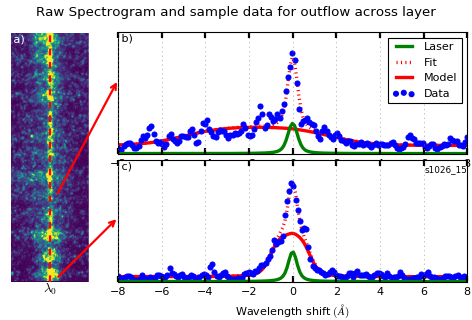

In [94]:
fig=plt.figure(figsize=(5.9,4))

ax1=fig.add_axes([0.0, 0.12, 0.2, 0.78])#l,b,w,h
ax1.imshow(roi, clim=[620,900], cmap=cmaps.viridis, interpolation='none')
ax1.plot([38,38],[0,243], lw=2, color='red', ls='--')
ax1.set_ylim([0,243])
ax1.axis('off')
ax1.text(x=38, y=0, va='top',ha='center',s=r'$\lambda_0$', fontsize=12)
ax1.text(x=0.1, y=0.99, va='top',ha='left',s=r' a)', color='white',fontsize=10,transform=ax1.transAxes)


ax2=fig.add_axes([0.25, 0.52, 0.74, 0.38])#l,b,w,h
ax3=fig.add_axes([0.25, 0.12, 0.74, 0.38],sharex=ax2)#l,b,w,h


for a, f, bk_frac in zip([ax2,ax3], [B9, B13],[0.38, 0.46]):
    r=0.3*f.Shot.max()/f.Response.max()
    a.plot(f.shift, f.Response*r, lw=3, color='green', label='Laser')
    a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1, ls=':')
    a.plot(f.shift, f.Fit-bk_frac*f.Response, lw=3, color='red', label='Model',zorder=1)

    a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2)

    a.set_ylim([0,None])
    a.tick_params(labelsize=10, pad=5, length=5, width=2)
    a.set_yticks([])

    a.xaxis.set_minor_locator(MultipleLocator(2))
    a.grid(which='minor', color='gray',linestyle=':')
    
   
ax2.legend(fontsize=10, loc=1)
#ax2.set_xticklabels([])
ax3.set_xlim([-8,8])
#ax3.set_xticks([-2,-1,0,1,2])
ax3.set_xlabel(r'Wavelength shift $(\AA)$',fontsize=10)
ax2.text(x=0, y=0.99, va='top',ha='left',s=r' b)',transform=ax2.transAxes,fontsize=10)
ax3.text(x=0, y=0.99, va='top',ha='left',s=r' c)',transform=ax3.transAxes,fontsize=10)
ax3.text(x=1, y=0.96, va='top',ha='right',s='s1026_15',transform=ax3.transAxes,fontsize=8)


fig.suptitle('Raw Spectrogram and sample data for outflow across layer', fontsize=12)

ax1.annotate('',xy=(0.25,0.75),xycoords='figure fraction',xytext=(0.12,0.39),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

ax1.annotate('',xy=(0.25,0.32),xycoords='figure fraction',xytext=(0.12,0.13),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))



In [98]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s1026_15_thomson_outflow.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

In [97]:
B9.Response

array([  1.15366587e+00,   1.17235667e+00,   1.19150545e+00,
         1.21114758e+00,   1.23125873e+00,   1.25187507e+00,
         1.27301365e+00,   1.29469226e+00,   1.31692947e+00,
         1.33974463e+00,   1.36315794e+00,   1.38719052e+00,
         1.41186438e+00,   1.43720256e+00,   1.46322912e+00,
         1.48996923e+00,   1.51744922e+00,   1.54569664e+00,
         1.57474035e+00,   1.60461056e+00,   1.63530713e+00,
         1.66692594e+00,   1.69947090e+00,   1.73297854e+00,
         1.76748721e+00,   1.80300037e+00,   1.83963287e+00,
         1.87739347e+00,   1.91628864e+00,   1.95644705e+00,
         1.99788146e+00,   2.04060218e+00,   2.08475403e+00,
         2.13035483e+00,   2.17741982e+00,   2.22611280e+00,
         2.27640576e+00,   2.32847700e+00,   2.38230007e+00,
         2.43806955e+00,   2.49576110e+00,   2.55558758e+00,
         2.61752751e+00,   2.68174757e+00,   2.74843040e+00,
         2.81756050e+00,   2.88933281e+00,   2.96396140e+00,
         3.04143943e+00,

In [14]:
%cd "C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns


In [15]:
%cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

s1026_15_532=NeLMap2('s1026_15 532nm neL.txt', scale=173, rot_angle=-90, multiply_by=1/1.6)
#s1026_15_532.set_origin(origin=(2377,1438), extent=[-11.5,11.5,-8,8])
s=s1026_15_532

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns


<IPython.core.display.Javascript object>


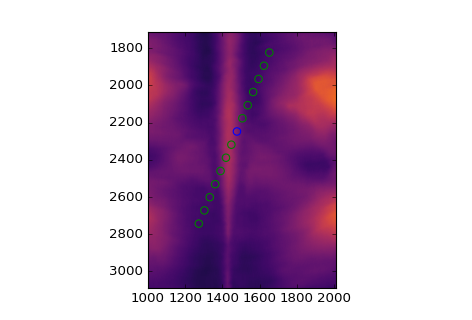

In [24]:
shot="s1026_15"
filename=shot+ ' pin positions'
f=[]
xx=[]
yy=[]
with open(filename+'.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    next(reader)
    for row in reader:
        f.append(float(row[0]))
        xx.append(s.data.shape[1]-float(row[2]))
        yy.append(float(row[1]))
        
xm, xc=np.polyfit(f,xx, 1)
ym, yc=np.polyfit(f, yy, 1)
scale=1 #useful if pin positions taken at different scale to shot
y=lambda f: scale*int(f*ym+yc)
x=lambda f: scale*int(f*xm+xc)
circles=[]
for i in range(1,15):
    color='green'
    if i is 7:
        color='blue'
    circles.append(plt.Circle((x(i),y(i)),20,color=color,fill=False))
fig, ax=plt.subplots(figsize=(5.9,4))
for c in circles:
    ax.add_artist(c)

ne1=s.plot_data_px(clim=[0,20], multiply_by=1e-17, ax=ax)

# s0429_16

In [138]:
%cd "~\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS"
shot="s0429_16"
filename=shot+ ' pin positions'
f=[]
xx=[]
yy=[]
with open(filename+'.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    next(reader)
    for row in reader:
        f.append(float(row[0]))
        xx.append(float(row[1]))
        yy.append(float(row[2]))        

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS


In [139]:
x0=4752/2
x0p=s.data.shape[1]/2
y0=3168/2
y0p=s.data.shape[0]/2
th=(90-22.5)/180*np.pi#s.rot_angle

xxr=[]
yyr=[]

for x,y in zip(xx,yy):
    xp=(x-x0)
    yp=(y-y0)
    xr=np.cos(th)*xp-np.sin(th)*yp
    yr=np.sin(th)*xp+np.cos(th)*yp
    xxr.append(xr+x0p)
    yyr.append(yr+y0p)
    
xm, xc=np.polyfit(f,xxr, 1)
ym, yc=np.polyfit(f, yyr, 1)
scale=1 #useful if pin positions taken at different scale to shot
y=lambda f: scale*int(f*ym+yc)
x=lambda f: scale*int(f*xm+xc)

In [64]:
iff=plt.imread('s0429_16 532nm end on interferometry (1).JPG')
ifr=rotate(iff, -90+22.5)

<IPython.core.display.Javascript object>


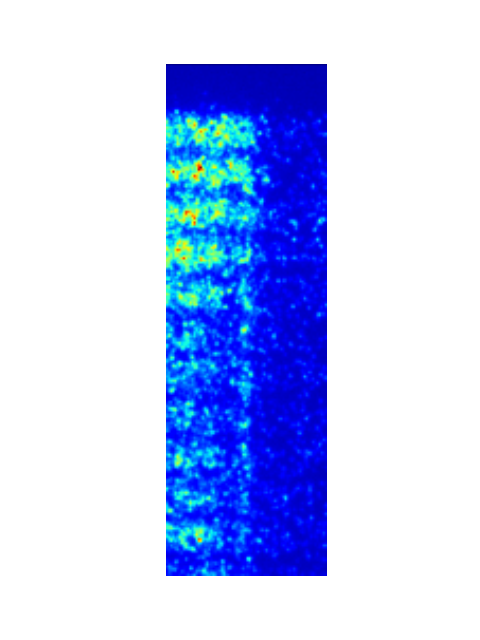

(-0.5, 4744.5, 5602.5, -0.5)

In [69]:
fig, ax=plt.subplots(figsize=(6,8))
ax.imshow(ifr)

for i in range(1,15):
    color='red'
    ax.add_artist(plt.Circle((x(i),y(i)),26,color=color,fill=False, lw=2))
    
#ax.set_ylim([4000, 1150])
#ax.set_xlim([1500,3200])
plt.axis('off')

In [140]:
%cd "~\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS\s0429_16 TS"
ts=np.loadtxt('s0429_16 shot.asc')
ts=np.rot90(ts)
l0=1028
w=60
roi=np.flipud(ts[219:493,l0-w:l0+w])

A1=TS_fibre_data("s0429_16 TS F1A.dat")
A10=TS_fibre_data("s0429_16 TS F10A.dat")

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS\s0429_16 TS


<IPython.core.display.Javascript object>


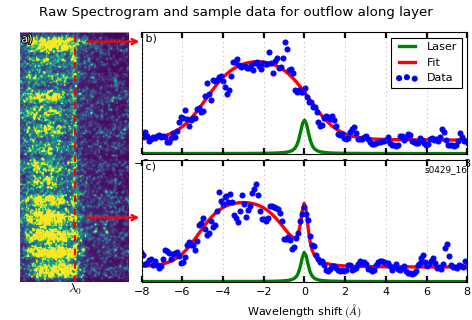

In [154]:
import matplotlib.patheffects as path_effects

fig=plt.figure(figsize=(5.9,4))

ax1=fig.add_axes([0.0, 0.12, 0.28, 0.78])#l,b,w,h
ax1.imshow(roi, clim=[620,1200], cmap=cmaps.viridis, interpolation='none')
ax1.plot([60,60],[0,274], lw=2, color='red', ls='--')
ax1.set_ylim([0,274])
ax1.axis('off')
ax1.text(x=60, y=0, va='top',ha='center',s=r'$\lambda_0$', fontsize=12)
t=ax1.text(x=0.15, y=0.99, va='top',ha='left',s=r'a)', color='white', fontsize=10,transform=ax1.transAxes)
t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

ax2=fig.add_axes([0.3, 0.52, 0.69, 0.38])#l,b,w,h
ax3=fig.add_axes([0.3, 0.12, 0.69, 0.38],sharex=ax2)#l,b,w,h


for a, f in zip([ax2,ax3], [A1, A10]):
    r=0.3*f.Shot.max()/f.Response.max()
    a.plot(f.shift, f.Response*r, lw=3, color='green', label='Laser')
    a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1)
    a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2)

    a.set_ylim([0,None])
    a.tick_params(labelsize=10, pad=5, length=5, width=2)
    a.set_yticks([])

    a.xaxis.set_minor_locator(MultipleLocator(2))
    a.grid(which='minor', color='gray',linestyle=':')
    
ax2.legend(fontsize=10, loc=1)
#ax2.set_xticklabels([])
ax3.set_xlim([-8,8])
#ax3.set_xticks([-2,-1,0,1,2])
ax3.set_xlabel(r'Wavelength shift $(\AA)$',fontsize=10)
ax2.text(x=0, y=0.99, va='top',ha='left',s=r' b)',transform=ax2.transAxes,fontsize=10)
ax3.text(x=0, y=0.99, va='top',ha='left',s=r' c)',transform=ax3.transAxes,fontsize=10)
ax3.text(x=1, y=0.96, va='top',ha='right',s='s0429_16',transform=ax3.transAxes,fontsize=8)


fig.suptitle('Raw Spectrogram and sample data for outflow along layer', fontsize=12)

ax1.annotate('',xy=(0.3,0.87),xycoords='figure fraction',xytext=(0.18,0.87),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

ax1.annotate('',xy=(0.3,0.32),xycoords='figure fraction',xytext=(0.18,0.32),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))


In [155]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0429_16_thomson_end_on_outflow.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)